In [1]:
import numpy as np
import pandas as pd
from pybedtools import BedTool
import gzip
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
snmf_introns = pd.read_csv('../code/CoveragePlots/bed_files/introns/snmf.retained_introns.bed.gz', sep='\t', 
                          names = ['chrom', 'start', 'end', 'ir_id', 'isoforms', 'strand'])
snmf_introns['gene'] = snmf_introns.ir_id.apply(lambda x: x.split('_')[0])

In [3]:
len(snmf_introns.gene.unique())

12472

In [4]:
snmf_introns.shape

(83553, 7)

In [5]:
def load_matrices_per_tissue(tissue, annotation):
    col_names = ['chrom', 'start', 'end', 'gene', 'score', 'strand']
    pos_names_intron = [f'bin_{str(i+1)}' for i in range(110)]
    pos_names = [f'bin_{str(i+1)}' for i in range(30)]

    if 'snmf' in annotation:
        fk1_file = f'../code/CoveragePlots/matrices/{tissue}.snmf.flanking_exons_1.mat.gz'
        fk2_file = f'../code/CoveragePlots/matrices/{tissue}.snmf.flanking_exons_2.mat.gz'
        intron_file = f'../code/CoveragePlots/matrices/{tissue}.{annotation}.retained_introns.mat.gz'
    elif 'gencode' in annotation:
        fk1_file = f'../code/CoveragePlots/matrices/{tissue}.gencode.flanking_exons_1.mat.gz'
        fk2_file = f'../code/CoveragePlots/matrices/{tissue}.gencode.flanking_exons_2.mat.gz'
        intron_file = f'../code/CoveragePlots/matrices/{tissue}.{annotation}.retained_introns.mat.gz'
    elif 'appris' in annotation:
        fk1_file = f'../code/CoveragePlots/matrices/{tissue}.appris_flanking_exons_1.mat.gz'
        fk2_file = f'../code/CoveragePlots/matrices/{tissue}.appris_flanking_exons_2.mat.gz'
        intron_file = f'../code/CoveragePlots/matrices/{tissue}.appris_introns.mat.gz'

    fk1 = pd.read_csv(fk1_file, sep='\t', skiprows=1, names=col_names + pos_names, index_col=3)

    fk2 = pd.read_csv(fk2_file, sep='\t', skiprows=1, names=col_names + pos_names, index_col=3)
    
    intron = pd.read_csv(intron_file, sep='\t', skiprows=1, names=col_names + pos_names_intron, index_col=3)

    return fk1, intron, fk2
    
def get_metaplot_input(tissue, annotation):
    fk1, intron, fk2 = load_matrices_per_tissue(tissue, annotation)
    
    col_names = ['chrom', 'start', 'end', 'gene', 'score', 'strand']
    pos_names_intron = [f'bin_{str(i+1)}' for i in range(110)]
    pos_names = [f'bin_{str(i+1)}' for i in range(30)]
    
    
    pos_introns = intron.loc[intron.strand == '+'].index
    neg_introns = intron.loc[intron.strand == '-'].index
    
    norm_factor_pos = pd.concat([fk1.loc[pos_introns, pos_names[5:25]], fk2.loc[pos_introns, pos_names[5:25]]], axis=1).mean(axis=1)
    norm_factor_neg = pd.concat([fk1.loc[neg_introns, pos_names[5:25]], fk2.loc[neg_introns, pos_names[5:25]]], axis=1).mean(axis=1)
    
    fk1_meta = fk1.loc[norm_factor_pos.index, pos_names[:25]]
    intron_meta = intron.loc[norm_factor_pos.index, pos_names_intron[6:-5]]
    fk2_meta = fk2.loc[norm_factor_pos.index, pos_names[5:]]
    meta_X_pos = pd.concat([fk1_meta, intron_meta, fk2_meta], axis=1)
    meta_X_pos.columns = [f'bin_{str(i+1)}' for i in range(meta_X_pos.shape[1])]
    idx = norm_factor_pos.loc[norm_factor_pos >= 0.01].index
    norm_X_pos = meta_X_pos.loc[idx].divide(norm_factor_pos.loc[idx], axis=0)
    
    
    fk1_meta = fk2.loc[norm_factor_neg.index, pos_names[:25]]
    intron_meta = intron.loc[norm_factor_neg.index, pos_names_intron[6:-5]]
    fk2_meta = fk1.loc[norm_factor_neg.index, pos_names[5:]]
    meta_X_neg = pd.concat([fk1_meta, intron_meta, fk2_meta], axis=1)
    meta_X_neg.columns = [f'bin_{str(i+1)}' for i in range(meta_X_pos.shape[1])]
    idx = norm_factor_neg.loc[norm_factor_neg >= 0.01].index
    norm_X_neg = meta_X_neg.loc[idx].divide(norm_factor_neg.loc[idx], axis=0)
    
    norm_X = pd.concat([norm_X_pos, norm_X_neg], axis=0)

    return norm_X

In [164]:
norm_X_snmf_gencode = get_metaplot_input('Liver', 'snmf_and_gencode')
norm_X_snmf = get_metaplot_input('Liver', 'snmf_only')
norm_X_snmf_all = get_metaplot_input('Liver', 'snmf')
norm_X_gencode = get_metaplot_input('Liver', 'gencode_only')
norm_X_appris = get_metaplot_input('Liver', 'appris_introns')

In [165]:
snmf_exons_bed = '/project2/mstephens/cfbuenabadn/gtex-stm/code/ebpmf_models/filtered/snmf_10/tables/snmf.merged_isoforms.exons.sorted.bed.gz'
snmf_exons = pd.read_csv(snmf_exons_bed, sep='\t', names = ['chrom', 'start', 'end', 'gene_id', 
                                                 'transcript_id', 'strand', 'factors', 'exon_id'])


annotation = pd.read_csv('/project2/mstephens/cfbuenabadn/gtex-stm/code/ebpmf_models/filtered/snmf_10/tables/annotated.snmf.merged_isoforms.tab.gz', sep='\t')
annotation = annotation.loc[annotation.appris_transcript_length != 'appris_transcript_length']
annotation['appris_transcript_length'] = annotation.appris_transcript_length.astype(int)
annotation['gene_id'] = [x.split('.')[0] for x in annotation.transcript]


In [166]:
col_names = ['chrom', 'start', 'end', 'intron_name', 'score', 'strand']
pos_names_intron = [f'bin_{str(i+1)}' for i in range(110)]
intron_snmf_only = pd.read_csv(f'../code/CoveragePlots/matrices/Liver.snmf_only.retained_introns.mat.gz', sep='\t', 
                   names=col_names + pos_names_intron, skiprows=1)

intron_gencode_only = pd.read_csv(f'../code/CoveragePlots/matrices/Liver.gencode_only.retained_introns.mat.gz', sep='\t', 
                   names=col_names + pos_names_intron, skiprows=1)

intron_snmf_gencode = pd.read_csv(f'../code/CoveragePlots/matrices/Liver.snmf_and_gencode.retained_introns.mat.gz', sep='\t', 
                   names=col_names + pos_names_intron, skiprows=1)

col_names = ['chrom', 'start', 'end', 'gene', 'score', 'strand']
pos_names_intron = [f'bin_{str(i+1)}' for i in range(110)]
appris_introns = pd.read_csv('../code/CoveragePlots/matrices/Liver.appris_introns.mat.gz', sep='\t', skiprows=1, 
                             names = col_names + pos_names_intron)

/tmp/jobs/41548387/ipykernel_15274/3125013857.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['0', '1e5', '2e5', '3e5', '4e5', '5e5', '6e5'])


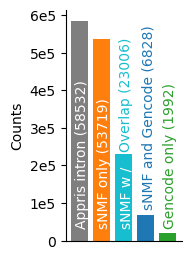

In [198]:
fig, ax = plt.subplots(figsize=(1.5, 3))

ax.bar(['No intron\nretention', 'sNMF only', 'sNMF overlaps', 'sNMF and Gencode', 'Gencode only'], [58532, 53719, 23006, 6828, 1992],
       color = ['tab:gray', 'tab:orange', 'tab:cyan', 'tab:blue', 'tab:green'])
ax.set_xticks([])

ax.text(-0.2, 4000, 'Appris intron (58532)', rotation=90, c='white')

ax.text(0.8, 4000, 'sNMF only (53719)', rotation=90, c='white')
ax.text(1.8, 4000, 'sNMF w / ', rotation=90, c='white')
ax.text(1.8, 24500, 'Overlap (23006)', rotation=90, c='tab:cyan')
ax.text(2.8, 9000, 'sNMF and Gencode (6828)', rotation=90, c='tab:blue')
ax.text(3.8, 4000, 'Gencode only (1992)', rotation=90, c='tab:green')
ax.set_yticklabels(['0', '1e5', '2e5', '3e5', '4e5', '5e5', '6e5'])
ax.set_ylabel('Counts')
ax.spines[['right', 'top']].set_visible(False)


plt.savefig('../code/scratch_figures/figure2/intron_barplot_w_overlaps.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure2/intron_barplot_w_overlaps.png', bbox_inches='tight', dpi=500)

/tmp/jobs/41548387/ipykernel_15274/4075579495.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['0', '1e5', '2e5', '3e5', '4e5', '5e5', '6e5'])


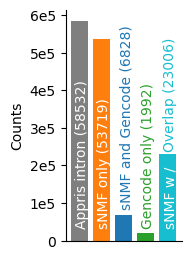

In [252]:
fig, ax = plt.subplots(figsize=(1.5, 3))

ax.bar(['No intron\nretention', 'sNMF only', 'sNMF overlaps', 'sNMF and Gencode', 'Gencode only'], [58532, 53719, 6828, 1992, 23006],
       color = ['tab:gray', 'tab:orange', 'tab:blue', 'tab:green', 'tab:cyan'])
ax.set_xticks([])

ax.text(-0.2, 4000, 'Appris intron (58532)', rotation=90, c='white')

ax.text(0.8, 4000, 'sNMF only (53719)', rotation=90, c='white')
ax.text(3.8, 4000, 'sNMF w / ', rotation=90, c='white')
ax.text(3.8, 24500, 'Overlap (23006)', rotation=90, c='tab:cyan')
ax.text(1.8, 9000, 'sNMF and Gencode (6828)', rotation=90, c='tab:blue')
ax.text(2.8, 4000, 'Gencode only (1992)', rotation=90, c='tab:green')
ax.set_yticklabels(['0', '1e5', '2e5', '3e5', '4e5', '5e5', '6e5'])
ax.set_ylabel('Counts')
ax.spines[['right', 'top']].set_visible(False)


plt.savefig('../code/scratch_figures/figure2/intron_barplot_w_overlaps_swapped.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure2/intron_barplot_w_overlaps_swapped.png', bbox_inches='tight', dpi=500)

In [191]:
appris_introns.shape

(58532, 116)

In [197]:
23006 + 53719 + 6828

83553

In [190]:
intron_snmf_only.shape

(53719, 116)

In [189]:
intron_gencode_only.shape

(1992, 116)

In [188]:
intron_snmf_gencode.shape

(6828, 116)

In [167]:
intron_snmf_only.intron_name.isin(snmf_introns.ir_id).sum()

53719

In [168]:
overlapping_introns = snmf_introns.loc[
    ~snmf_introns.ir_id.isin(pd.Index(intron_snmf_only.intron_name).union(pd.Index(intron_snmf_gencode.intron_name)))
]

In [169]:
gencode_exons_file = '/project2/mstephens/cfbuenabadn/gtex-stm/code/Annotations/gencode.v44.primary_assembly.exons.bed.gz'
gencode_exons = pd.read_csv(gencode_exons_file, sep='\t')

gencode_exons_bed = BedTool.from_dataframe(gencode_exons)

In [170]:
overlapping_introns_bed = BedTool.from_dataframe(overlapping_introns)

In [183]:
overlapping_introns_ = overlapping_introns_bed.intersect(all_gencode_exons_bed, wo=True).to_dataframe(
    names = list(overlapping_introns.columns) + [f'{x}_gencode' for x in all_gencode_exons.columns] + ['overlap']
)

In [184]:
overlapping_introns_.transcript_type_gencode.unique()

array(['protein_coding_CDS_not_defined', 'retained_intron', 'lncRNA',
       'protein_coding', 'nonsense_mediated_decay', 'misc_RNA', 'TEC',
       'processed_transcript', 'processed_pseudogene', 'snRNA', 'miRNA',
       'rRNA_pseudogene', 'snoRNA', 'unprocessed_pseudogene',
       'transcribed_processed_pseudogene', 'non_stop_decay',
       'unitary_pseudogene', 'transcribed_unitary_pseudogene', 'scaRNA',
       'transcribed_unprocessed_pseudogene', 'pseudogene', 'rRNA'],
      dtype=object)

In [219]:
annot_overlap = {
    'other_gene':0,
    'retained_intron':0,
    'non_stop_decay':0,
    'nonsense_mediated_decay':0,
    'processed_transcript':0,
    'pseudogene':0,
    'protein_coding_CDS_not_defined':0,
    'TEC':0,
    'protein_coding':0,
    'other':0
}

other_genes = []
for intron, df in overlapping_introns_.groupby('ir_id'):


    if np.sum(df.gene == df.gene_id_gencode) == 0:
         annot_overlap['other_gene'] += 1
         other_genes.extend(list(df.gene_id_gencode.unique()))
    else:
        if 'retained_intron' in list(df.transcript_type_gencode):
            annot_overlap['retained_intron'] += 1
        elif 'nonsense_mediated_decay' in list(df.transcript_type_gencode):
            annot_overlap['nonsense_mediated_decay'] += 1
        elif 'non_stop_decay' in list(df.transcript_type_gencode):
            annot_overlap['non_stop_decay'] += 1
        elif 'protein_coding_CDS_not_defined' in list(df.transcript_type_gencode):
            annot_overlap['protein_coding_CDS_not_defined'] += 1
        elif 'processed_transcript' in list(df.transcript_type_gencode):
            annot_overlap['processed_transcript'] += 1
        elif any(['pseudogene' in x for x in list(df.transcript_type_gencode)]):
            annot_overlap['pseudogene'] += 1
        elif 'TEC' in list(df.transcript_type_gencode):
            annot_overlap['TEC'] += 1
        elif 'protein_coding' in list(df.transcript_type_gencode):
            annot_overlap['protein_coding'] += 1
        else:
            annot_overlap['other'] += 1

In [227]:
gencode_exons.loc[gencode_exons.gene_id.isin(other_genes)].gene_type.value_counts()

gene_type
protein_coding                        42820
lncRNA                                19251
transcribed_processed_pseudogene        532
processed_pseudogene                    426
transcribed_unitary_pseudogene          400
miRNA                                   166
misc_RNA                                129
snRNA                                    79
unprocessed_pseudogene                   68
snoRNA                                   52
TEC                                      48
transcribed_unprocessed_pseudogene       23
rRNA_pseudogene                          20
pseudogene                                3
unitary_pseudogene                        1
Name: count, dtype: int64

In [220]:
list(df.transcript_type_gencode)

['retained_intron',
 'protein_coding',
 'protein_coding_CDS_not_defined',
 'protein_coding_CDS_not_defined',
 'nonsense_mediated_decay']

In [221]:
annot_overlap

{'other_gene': 3261,
 'retained_intron': 10613,
 'non_stop_decay': 16,
 'nonsense_mediated_decay': 2077,
 'processed_transcript': 5,
 'pseudogene': 54,
 'protein_coding_CDS_not_defined': 3825,
 'TEC': 30,
 'protein_coding': 3125,
 'other': 0}

In [199]:
2077 + 16+5+3825+30

5953

In [200]:
3261+54

3315

In [204]:
5953+3315+3125+10613

23006

/tmp/jobs/41548387/ipykernel_15274/2404502956.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['0', '5e3', '1e4', '1.5e4', '2e4'])


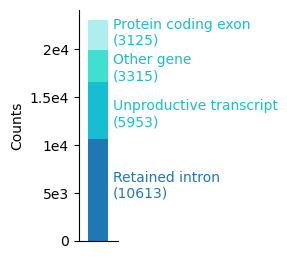

In [261]:
fig, ax = plt.subplots(figsize=(0.5, 3))

ax.bar([0, 0, 0, 0], [23006, 23006-3125, 10613 + 5953, 10613],#[10613, 5953, 3825, 3315],
       color = ['paleturquoise', 'turquoise', 'tab:cyan', 'tab:blue'])
ax.set_xticks([])

ax.text(0.6, 4500, 'Retained intron\n(10613)', c='tab:blue')
ax.text(0.6, 12000, 'Unproductive transcript\n(5953)', c='tab:cyan')

ax.text(0.6, 16800, 'Other gene\n(3315)', c='tab:cyan')
ax.text(0.6, 20500, 'Protein coding exon\n(3125)', c='tab:cyan')
ax.set_yticklabels(['0', '5e3', '1e4', '1.5e4', '2e4'])
ax.set_ylabel('Counts')
ax.spines[['right', 'top']].set_visible(False)
ax.set_xlim([-0.8, 0.8])


plt.savefig('../code/scratch_figures/figure2/intron_barplot_for_overlaps.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure2/intron_barplot_for_overlaps.png', bbox_inches='tight', dpi=500)

In [177]:
3261 + 10613 + 16 + 2077 + 5 + 54 + 3825 + 30 + 3125 

23006

In [65]:
def load_matrices_per_tissue(tissue, annotation):
    col_names = ['chrom', 'start', 'end', 'gene', 'score', 'strand']
    pos_names_intron = [f'bin_{str(i+1)}' for i in range(110)]
    pos_names = [f'bin_{str(i+1)}' for i in range(30)]

    if 'snmf' in annotation:
        fk1_file = f'../code/CoveragePlots/matrices/{tissue}.snmf.flanking_exons_1.mat.gz'
        fk2_file = f'../code/CoveragePlots/matrices/{tissue}.snmf.flanking_exons_2.mat.gz'
        intron_file = f'../code/CoveragePlots/matrices_split/{tissue}.{annotation}.retained_introns.mat.gz'
    elif 'gencode' in annotation:
        fk1_file = f'../code/CoveragePlots/matrices/{tissue}.gencode.flanking_exons_1.mat.gz'
        fk2_file = f'../code/CoveragePlots/matrices/{tissue}.gencode.flanking_exons_2.mat.gz'
        intron_file = f'../code/CoveragePlots/matrices_split/{tissue}.{annotation}.retained_introns.mat.gz'
    elif 'appris' in annotation:
        fk1_file = f'../code/CoveragePlots/matrices/{tissue}.appris_flanking_exons_1.mat.gz'
        fk2_file = f'../code/CoveragePlots/matrices/{tissue}.appris_flanking_exons_2.mat.gz'
        intron_file = f'../code/CoveragePlots/matrices_split/{tissue}.appris_introns.mat.gz'

    fk1 = pd.read_csv(fk1_file, sep='\t', skiprows=1, names=col_names + pos_names, index_col=3)

    fk2 = pd.read_csv(fk2_file, sep='\t', skiprows=1, names=col_names + pos_names, index_col=3)
    
    intron = pd.read_csv(intron_file, sep='\t', skiprows=1, names=col_names + pos_names_intron, index_col=3)

    return fk1, intron, fk2


def get_metaplot_input(tissue, annotation):
    fk1, intron, fk2 = load_matrices_per_tissue(tissue, annotation)
    
    col_names = ['chrom', 'start', 'end', 'gene', 'score', 'strand']
    pos_names_intron = [f'bin_{str(i+1)}' for i in range(110)]
    pos_names = [f'bin_{str(i+1)}' for i in range(30)]
    
    
    pos_introns = intron.loc[intron.strand == '+'].index
    neg_introns = intron.loc[intron.strand == '-'].index
    
    norm_factor_pos = pd.concat([fk1.loc[pos_introns, pos_names[5:25]], fk2.loc[pos_introns, pos_names[5:25]]], axis=1).mean(axis=1)
    norm_factor_neg = pd.concat([fk1.loc[neg_introns, pos_names[5:25]], fk2.loc[neg_introns, pos_names[5:25]]], axis=1).mean(axis=1)
    
    fk1_meta = fk1.loc[norm_factor_pos.index, pos_names[:25]]
    intron_meta = intron.loc[norm_factor_pos.index, pos_names_intron[6:-5]]
    fk2_meta = fk2.loc[norm_factor_pos.index, pos_names[5:]]
    meta_X_pos = pd.concat([fk1_meta, intron_meta, fk2_meta], axis=1)
    meta_X_pos.columns = [f'bin_{str(i+1)}' for i in range(meta_X_pos.shape[1])]
    idx = norm_factor_pos.loc[norm_factor_pos >= 0.01].index
    norm_X_pos = meta_X_pos.loc[idx].divide(norm_factor_pos.loc[idx], axis=0)
    
    
    fk1_meta = fk2.loc[norm_factor_neg.index, pos_names[:25]]
    intron_meta = intron.loc[norm_factor_neg.index, pos_names_intron[6:-5]]
    fk2_meta = fk1.loc[norm_factor_neg.index, pos_names[5:]]
    meta_X_neg = pd.concat([fk1_meta, intron_meta, fk2_meta], axis=1)
    meta_X_neg.columns = [f'bin_{str(i+1)}' for i in range(meta_X_pos.shape[1])]
    idx = norm_factor_neg.loc[norm_factor_neg >= 0.01].index
    norm_X_neg = meta_X_neg.loc[idx].divide(norm_factor_neg.loc[idx], axis=0)
    
    norm_X = pd.concat([norm_X_pos, norm_X_neg], axis=0)

    return norm_X

In [67]:
norm_X_snmf_gencode = get_metaplot_input('Liver', 'snmf_and_gencode')
norm_X_snmf = get_metaplot_input('Liver', 'snmf_only')
norm_X_snmf_vastdb = get_metaplot_input('Liver', 'snmf_and_vastdb')
norm_X_gencode = get_metaplot_input('Liver', 'gencode_only')
norm_X_snmf_gencode_vastdb = get_metaplot_input('Liver', 'snmf_and_gencode_and_vastdb')
norm_X_appris = get_metaplot_input('Liver', 'appris_introns')

In [72]:
366  + 2883  + 5669 + 32374 

41292

In [71]:
norm_X_snmf

,bin_1,bin_2,bin_3,bin_4,bin_5,bin_6,bin_7,bin_8,bin_9,bin_10,...,bin_140,bin_141,bin_142,bin_143,bin_144,bin_145,bin_146,bin_147,bin_148,bin_149
gene,,,,,,,,,,,,,,,,,,,,,
ENSG00000187634_snmf_intron_2,0.165577,0.190243,0.077510,0.119778,0.250132,0.704614,0.697569,0.695803,0.577791,0.546081,...,0.587190,0.641984,0.923826,0.884685,0.715190,0.088086,0.133885,0.116265,0.137399,0.119778
ENSG00000215915_snmf_intron_1,0.664149,0.644660,0.679465,0.579216,0.682249,0.592933,0.583475,0.582211,0.796266,0.780747,...,1.271678,1.308809,1.347096,1.336657,1.301845,0.048733,0.022280,0.079365,0.036201,0.004180
ENSG00000215915_snmf_intron_3,0.012265,0.001938,0.005164,0.010330,0.085215,0.654184,0.671401,0.687538,0.695071,0.771465,...,0.790026,0.834637,0.815042,0.823919,0.857004,0.019367,0.013556,0.000000,0.000000,0.000000
ENSG00000215915_snmf_intron_5,0.020015,0.007276,0.013948,0.018802,0.073387,0.612560,0.954216,1.008801,1.126056,1.111905,...,0.882016,1.290822,1.656739,1.776014,1.918254,0.000000,0.002425,0.004246,0.000000,0.002425
ENSG00000215915_snmf_intron_6,0.002694,0.000000,0.001685,0.005726,0.065348,0.537830,0.514811,0.513127,0.505749,0.435653,...,1.397344,1.336713,1.273273,1.264290,1.115437,0.115874,0.109137,0.100717,0.090612,0.116885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000268738_snmf_intron_1,0.601908,0.505863,0.326578,0.288133,0.268945,0.517697,0.824819,0.759697,0.799847,0.424361,...,1.612297,1.962008,1.443943,0.686285,0.433454,0.243337,0.128070,0.089659,0.064019,0.064019
ENSG00000197021_snmf_intron_1,0.016772,0.018031,0.020127,0.018240,0.016563,0.811771,0.910337,0.891019,0.830519,0.814048,...,0.831792,0.918129,0.796526,0.562589,0.181198,0.026626,0.031028,0.028094,0.028932,0.027254
ENSG00000130830_snmf_intron_1,0.029984,0.030772,0.031562,0.031562,0.037085,1.059290,1.104659,1.100715,1.078358,1.036933,...,1.219689,1.075728,0.875219,0.528260,0.209295,0.004209,0.000000,0.000000,0.000000,0.000000


In [70]:
norm_X_snmf_gencode_vastdb

,bin_1,bin_2,bin_3,bin_4,bin_5,bin_6,bin_7,bin_8,bin_9,bin_10,...,bin_140,bin_141,bin_142,bin_143,bin_144,bin_145,bin_146,bin_147,bin_148,bin_149
gene,,,,,,,,,,,,,,,,,,,,,
ENSG00000187634_snmf_intron_9,0.038207,0.121908,0.078238,0.074600,0.138285,0.647766,0.697497,0.836998,0.921915,1.193631,...,0.786964,0.818806,0.809706,0.814256,0.746021,0.141924,0.090977,0.110993,0.136471,0.134647
ENSG00000187634_snmf_intron_10,0.478224,0.561189,0.583137,0.395272,0.514821,1.716075,1.695745,1.402953,1.396852,1.311453,...,1.396609,1.498109,1.374164,1.439551,1.592780,0.441627,0.441627,0.453830,0.400150,0.485548
ENSG00000187961_snmf_intron_2,0.001601,0.052708,0.073472,0.122986,0.100622,0.145075,0.245722,0.340324,0.450903,0.425095,...,1.208541,1.155299,1.083429,1.075440,1.031329,0.313049,0.394509,0.437628,0.445616,0.391315
ENSG00000187961_snmf_intron_4,0.317394,0.268902,0.285432,0.246860,0.315190,0.867619,0.884650,0.873632,0.950777,1.032927,...,1.212262,1.276553,1.305937,1.326144,1.399612,0.652416,0.575271,0.525681,0.538908,0.544415
ENSG00000169972_snmf_intron_3,0.056142,0.062379,0.047564,0.042887,0.118520,0.742493,0.752023,0.810937,0.769349,0.772817,...,1.235899,1.325569,1.244672,1.239799,1.309001,0.077974,0.084211,0.070178,0.069397,0.074074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000196924_snmf_intron_8,0.024418,0.029726,0.029373,0.029549,0.040342,0.911917,0.906388,0.946642,0.972299,1.052302,...,0.947527,0.942219,0.949590,0.919216,0.885892,0.105635,0.018048,0.014863,0.013447,0.013447
ENSG00000196924_snmf_intron_9,0.013676,0.013676,0.011747,0.010345,0.010695,0.920344,0.892275,0.880176,0.860890,0.840375,...,1.027236,1.045429,1.062524,1.007733,1.033466,0.153592,0.043658,0.039100,0.037171,0.034365
ENSG00000196924_snmf_intron_11,0.004646,0.004646,0.004646,0.004646,0.010452,0.855070,0.887256,0.872324,0.868343,0.864361,...,1.229351,1.266623,1.264523,1.232556,1.177976,0.186974,0.085242,0.091048,0.074325,0.078738


In [68]:
norm_X_snmf_vastdb

,bin_1,bin_2,bin_3,bin_4,bin_5,bin_6,bin_7,bin_8,bin_9,bin_10,...,bin_140,bin_141,bin_142,bin_143,bin_144,bin_145,bin_146,bin_147,bin_148,bin_149
gene,,,,,,,,,,,,,,,,,,,,,
ENSG00000187634_snmf_intron_3,0.951212,1.127739,1.073803,1.063973,1.274827,2.424325,2.228215,2.053864,1.814161,1.737903,...,0.833536,0.931604,0.833536,0.882557,0.931604,0.191220,0.009804,0.024523,0.156893,0.264765
ENSG00000187634_snmf_intron_4,0.027042,0.015447,0.003872,0.038618,0.127468,0.733896,0.733896,0.753215,0.733896,0.637322,...,1.178090,1.139472,1.126586,1.416289,1.815412,0.027042,0.073384,0.061808,0.050213,0.027042
ENSG00000187634_snmf_intron_5,0.112090,0.097337,0.103235,0.120929,0.200572,0.929116,1.027424,0.997935,0.968430,1.108192,...,0.949751,1.113458,1.274209,1.260935,1.097228,0.041300,0.000000,0.017693,0.011796,0.000000
ENSG00000187634_snmf_intron_11,0.123446,0.136742,0.150039,0.153836,0.146241,0.957513,0.982261,0.814375,0.669274,0.284877,...,1.459218,1.503530,1.427559,1.335763,1.397267,0.288675,0.286781,0.246892,0.169027,0.159528
ENSG00000187634_snmf_intron_12,0.220709,0.247048,0.269616,0.311000,0.386246,0.810942,0.796316,0.796316,0.810942,0.818707,...,1.391984,1.479767,1.396161,1.256544,1.241499,0.328559,0.285918,0.275888,0.267108,0.258335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000185010_snmf_intron_16,0.555187,0.585190,0.300116,0.345082,0.495179,1.650597,1.900655,1.750636,1.750636,1.800616,...,0.300116,0.300116,0.450134,0.450134,0.436504,0.030004,0.000000,0.000000,0.000000,0.000000
ENSG00000185010_snmf_intron_17,0.532684,0.675365,0.656344,0.570775,0.570775,1.379336,1.236605,1.284182,1.300024,1.236605,...,0.618302,0.697564,0.745141,0.856138,0.837117,0.865623,1.046396,1.027326,1.046396,1.141501
ENSG00000155962_snmf_intron_1,0.062557,0.062557,0.062557,0.040659,0.031270,0.907030,0.856982,0.844473,0.813203,0.849682,...,0.875760,0.880218,0.880969,0.792351,0.813203,0.081319,0.000000,0.000000,0.000000,0.000000


In [69]:
norm_X_snmf_gencode

,bin_1,bin_2,bin_3,bin_4,bin_5,bin_6,bin_7,bin_8,bin_9,bin_10,...,bin_140,bin_141,bin_142,bin_143,bin_144,bin_145,bin_146,bin_147,bin_148,bin_149
gene,,,,,,,,,,,,,,,,,,,,,
ENSG00000160072_snmf_intron_8,0.019881,0.014561,0.019601,0.029121,0.138049,0.963263,1.006199,1.081804,1.051935,1.020200,...,0.985664,1.140607,1.237680,1.258682,1.284483,0.000281,0.001120,0.001960,0.000000,0.001120
ENSG00000197785_snmf_intron_3,0.051804,0.066936,0.082837,0.096685,0.175675,0.670898,0.688851,0.725781,0.733987,0.753478,...,1.234425,1.267765,1.328462,1.303669,1.300250,0.007693,0.001283,0.005129,0.007951,0.005898
ENSG00000149527_snmf_intron_4,0.007730,0.007730,0.007730,0.007730,0.064942,0.518207,0.672057,0.661235,0.585656,0.653113,...,1.773890,1.829589,1.485570,1.422832,0.670139,0.046391,0.046391,0.050254,0.062625,0.077314
ENSG00000160050_snmf_intron_5,0.372564,0.332067,0.309794,0.346242,0.449500,1.052882,1.052882,1.073136,1.012395,1.052882,...,0.783586,0.664133,0.578191,0.473803,0.388759,0.323969,0.279423,0.277393,0.309794,0.317891
ENSG00000198198_snmf_intron_1,0.011141,0.020050,0.020050,0.022271,0.075732,0.565795,0.630397,0.663809,0.739553,0.772965,...,1.033586,0.957854,0.926663,0.886564,0.997953,0.071278,0.133660,0.133660,0.169293,0.171526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000187243_snmf_intron_2,0.000000,0.000000,0.000000,0.000000,0.000000,0.441730,0.337979,0.512512,0.481701,0.329984,...,1.855382,1.888876,1.833033,2.056582,1.654182,0.145298,0.000000,0.000000,0.000000,0.000000
ENSG00000126012_snmf_intron_7,0.140715,0.133700,0.133700,0.163509,0.161756,1.158526,1.081293,1.115631,1.067410,1.019190,...,0.918054,0.914923,0.910696,0.930580,0.973788,0.210851,0.124495,0.121863,0.110906,0.108713
ENSG00000010671_snmf_intron_2,0.459916,0.459916,0.476931,0.471269,0.499667,0.766516,0.700263,0.738118,0.738118,0.662439,...,1.391100,1.324847,1.334304,1.305935,1.158282,0.221435,0.113563,0.113563,0.113563,0.113563


In [6]:
snmf_cassette_exons = pd.read_csv('../code/ebpmf_models/filtered/snmf_10/tables/cassette_exons.bed.gz', sep='\t')

In [7]:
len(snmf_cassette_exons.gene.unique())

8774

In [8]:
gencode_exons_file = '/project2/mstephens/cfbuenabadn/gtex-stm/code/Annotations/gencode.v44.primary_assembly.exons.sorted.bed.gz'
gencode_exons_df = pd.read_csv(gencode_exons_file, sep='\t', 
                            names = ['chrom', 'start', 'end', 'gene_id', 
                                                           'transcript_id', 'strand', 'exon_id', 'transcript_support_level',
                                                           'basic', 'Ensembl_canonical', 'MANE_Select', 'appris', 'transcript_type'])

gencode_exons_bed = BedTool.from_dataframe(gencode_exons_df)


vastdb_exons_df = pd.read_csv('/project2/yangili1/cfbuenabadn/CSQ_additional_files/EVENT_INFO-hg38.tab.gz', sep='\t')
vastdb_exons_df = vastdb_exons_df.dropna()
vastdb_exons_cols = list(vastdb_exons_df.columns)
vastdb_exons_df['chrom'] = vastdb_exons_df.CO_A.apply(lambda x: x.split(':')[0])
vastdb_exons_df['start'] = vastdb_exons_df.CO_A.apply(lambda x: x.split(':')[1].split('-')[0])
vastdb_exons_df['end'] = vastdb_exons_df.CO_A.apply(lambda x: x.split('-')[1])
vastdb_exons_cols = ['chrom', 'start', 'end'] + vastdb_exons_cols
vastdb_exons_df = vastdb_exons_df[vastdb_exons_cols]

vastdb_exons_df = vastdb_exons_df.loc[(~vastdb_exons_df.COMPLEX.isin(['MIC-S', 'MIC_S', 'IR', 'Alt3', 'Alt5', 'MIC-M'])) & (vastdb_exons_df.EVENT.apply(lambda x: x.startswith('HsaEX')))]
vastdb_exons_df = vastdb_exons_df.loc[(~ vastdb_exons_df.COMPLEX.apply(lambda x: (x.startswith('ME') or (x == 'A_NA') or (x == 'ANN') or x == 'NA*')))]
vastdb_exons_df = vastdb_exons_df[[x for x in vastdb_exons_df.columns if x not in ['Seq_C1', 'Seq_A', 'Seq_C2']]]
vastdb_exons_df['strand'] = vastdb_exons_df.REF_CO.apply(lambda x: x.split(':')[-1])

intron_start_list = []
intron_end_list = []
for idx, row in vastdb_exons_df.iterrows():
    strand = row.strand
    if strand == '+':
        intron_start = int(row.CO_C1.split('-')[-1])
        intron_end = int(row.CO_C2.split('-')[0].split(':')[1])
    else:
        intron_start = int(row.CO_C2.split('-')[-1])
        intron_end = int(row.CO_C1.split('-')[0].split(':')[1])
        
    intron_start_list.append(intron_start)
    intron_end_list.append(intron_end)

vastdb_introns_df = pd.DataFrame()
vastdb_introns_df['chrom'] = list(vastdb_exons_df.chrom)
vastdb_introns_df['start'] = intron_start_list
vastdb_introns_df['end'] = intron_end_list
vastdb_introns_df['GENE'] = list(vastdb_exons_df.GENE)
vastdb_introns_df['EVENT'] = list(vastdb_exons_df.EVENT)
vastdb_introns_df['strand'] = list(vastdb_exons_df.strand)

vastdb_introns_bed = BedTool.from_dataframe(vastdb_introns_df).sort()
vastdb_exons_bed = BedTool.from_dataframe(vastdb_exons_df).sort()


# snmf_cassette_exons = pd.read_csv('../code/ebpmf_models/filtered/snmf_10/tables/cassette_exons.bed.gz', sep='\t')
snmf_cassette_exons_bed = BedTool.from_dataframe(snmf_cassette_exons)

snmf_vastdb_cassette_exons = snmf_cassette_exons_bed.intersect(vastdb_exons_bed, f=1, F=1, wo=True).to_dataframe(
    names = list(snmf_cassette_exons.columns) + [f'{x}_vastdb' for x in vastdb_exons_df.columns] + ['overlaps']
)


intron_start_vastdb = []
intron_end_vastdb = []
for idx, row in snmf_vastdb_cassette_exons.iterrows():
    if row.strand_vastdb == '+':
        intron_start = row.CO_C1_vastdb
        intron_end = row.CO_C2_vastdb
    else:
        intron_start = row.CO_C2_vastdb
        intron_end = row.CO_C1_vastdb
    intron_start = int(intron_start.split('-')[-1])
    intron_end = int(intron_end.split(':')[-1].split('-')[0])

    intron_start_vastdb.append(intron_start)
    intron_end_vastdb.append(intron_end)

snmf_vastdb_cassette_exons['intron_start_vastdb'] = intron_start_vastdb
snmf_vastdb_cassette_exons['intron_end_vastdb'] = intron_end_vastdb

snmf_vastdb_cassette_exons_confirmed = snmf_vastdb_cassette_exons.loc[
(snmf_vastdb_cassette_exons.intron_start == snmf_vastdb_cassette_exons.intron_start_vastdb) & (snmf_vastdb_cassette_exons.intron_end == snmf_vastdb_cassette_exons.intron_end_vastdb)
]

In [9]:
snmf_vastdb_cassette_exons_confirmed['annot'] = snmf_vastdb_cassette_exons_confirmed[
['chrom', 'start', 'end', 'intron_start', 'intron_end']].astype(str).agg(':'.join, axis=1)

/tmp/jobs/41557464/ipykernel_40459/3589894801.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  snmf_vastdb_cassette_exons_confirmed['annot'] = snmf_vastdb_cassette_exons_confirmed[


In [10]:
def load_matrices_per_tissue(tissue, annotation, exon_type):
    col_names = ['chrom', 'start', 'end', 'gene', 'score', 'strand']
    pos_names = [f'bin_{str(i+1)}' for i in range(120)]
    
    col_names += pos_names
    fk1 = pd.read_csv(f'../code/CoveragePlots/matrices/cassette_exons/{tissue}.{annotation}.{exon_type}.flanking1.mat.gz', sep='\t', skiprows=1,
                             names=col_names)

    fk2 = pd.read_csv(f'../code/CoveragePlots/matrices/cassette_exons/{tissue}.{annotation}.{exon_type}.flanking2.mat.gz', sep='\t', skiprows=1,
                                 names=col_names)
    
    exon = pd.read_csv(f'../code/CoveragePlots/matrices/cassette_exons/{tissue}.{annotation}.{exon_type}.exon.mat.gz', sep='\t', skiprows=1,
                                 names=col_names)

    return fk1, exon, fk2
    
snmf_cassette_exons = pd.read_csv('../code/ebpmf_models/filtered/snmf_10/tables/cassette_exons.bed.gz', sep='\t')


col_names = ['chrom', 'start', 'end', 'gene', 'score', 'strand']
pos_names = [f'bin_{str(i+1)}' for i in range(120)]
gencode_snmf_cassette_exons = pd.read_csv('../code/CoveragePlots/bed_files/cassette_exons/gencode/cassette_exon.exon.bed', 
                                          sep='\t', names = ['chrom', 'start', 'end', 'name', 'transcripts'])


snmf_gencode_cassette_exons = pd.read_csv('../code/CoveragePlots/bed_files/cassette_exons/snmf/gencode.exon.bed',
                                          sep='\t', names = ['chrom', 'start', 'end', 'name', 'transcripts'])

snmf_gencode_fk1 = pd.read_csv('../code/CoveragePlots/bed_files/cassette_exons/snmf/gencode.flanking1.bed',
                                          sep='\t', names = ['chrom', 'start', 'end', 'name', 'transcripts'])
snmf_gencode_fk2 = pd.read_csv('../code/CoveragePlots/bed_files/cassette_exons/snmf/gencode.flanking2.bed',
                                          sep='\t', names = ['chrom', 'start', 'end', 'name', 'transcripts'])

fk1, exon, fk2 = load_matrices_per_tissue('Liver', 'gencode', 'cassette_exon')
gencode_exon = exon[['chrom', 'start', 'end']].copy()
gencode_exon['intron_start'] = fk1.end
gencode_exon['intron_end'] = fk2.start

gencode_exon['annot'] = gencode_exon.chrom + ':' + gencode_exon.start.astype(str) + ':' + gencode_exon.end.astype(str) + ':'+ gencode_exon.intron_start.astype(str) + ':' + gencode_exon.intron_end.astype(str) 

snmf_exon = snmf_gencode_cassette_exons[['chrom', 'start', 'end']].copy()
snmf_exon['intron_start'] = snmf_gencode_fk1.end
snmf_exon['intron_end'] = snmf_gencode_fk2.start

snmf_exon['annot'] = snmf_exon.chrom + ':' + snmf_exon.start.astype(str) + ':' + snmf_exon.end.astype(str) + ':' + snmf_exon.intron_start.astype(str) + ':' + snmf_exon.intron_end.astype(str) 

In [11]:
snmf_gencode_exons = snmf_cassette_exons_bed.intersect(gencode_exons_bed, f=1, F=1, u=True).to_dataframe(names = snmf_cassette_exons.columns)
snmf_vastdb_exons = snmf_cassette_exons_bed.intersect(vastdb_exons_bed, f=1, F=1, u=True).to_dataframe(names = snmf_cassette_exons.columns)

snmf_vastdb_exons['annot'] = snmf_vastdb_exons[
['chrom', 'start', 'end', 'intron_start', 'intron_end']].astype(str).agg(':'.join, axis=1)

snmf_gencode_exons['annot'] = snmf_gencode_exons[
['chrom', 'start', 'end', 'intron_start', 'intron_end']].astype(str).agg(':'.join, axis=1)

# snmf_junctions_cassette_exons

snmf_cassette_exons['annot'] =  snmf_cassette_exons[
['chrom', 'start', 'end', 'intron_start', 'intron_end']].astype(str).agg(':'.join, axis=1)

exons_by_both = pd.Index(snmf_cassette_exons.loc[snmf_cassette_exons.annot.isin(pd.Index(
    snmf_vastdb_cassette_exons_confirmed.annot).intersection(pd.Index(gencode_exon.annot).intersection(pd.Index(snmf_exon.annot))))].transcripts)

In [12]:
# Gencode & sNMF
len(pd.Index(gencode_exon.annot).intersection(pd.Index(snmf_exon.annot)))

3802

In [13]:
# Gencode & VastDB & sNMF
len(exons_by_both)

3003

In [14]:
# VastDB & sNMF 
len(snmf_vastdb_cassette_exons_confirmed.annot.unique())

12259

In [15]:
len(exons_by_any)

NameError: name 'exons_by_any' is not defined

In [16]:
# Exons by (Gencode or VastDB) & sNMF
len(pd.Index(snmf_vastdb_cassette_exons_confirmed.annot).union(pd.Index(gencode_exon.annot).intersection(pd.Index(snmf_exon.annot))).unique())

13058

In [17]:
snmf_gencode_cassette_exons = pd.read_csv('../code/CoveragePlots/bed_files/cassette_exons/snmf/gencode.exon.bed',
                                          sep='\t', names = ['chrom', 'start', 'end', 'name', 'transcripts'])

snmf_vastdb_cassette_exons = pd.read_csv('../code/CoveragePlots/bed_files/cassette_exons/snmf/vastdb.exon.bed',
                                          sep='\t', names = ['chrom', 'start', 'end', 'name', 'transcripts'])

snmf_junctions_cassette_exons = pd.read_csv('../code/CoveragePlots/bed_files/cassette_exons/snmf/junctions.exon.bed',
                                          sep='\t', names = ['chrom', 'start', 'end', 'name', 'transcripts'])

In [18]:
transcripts_annotated = pd.Index(snmf_gencode_exons.transcripts).union(pd.Index(snmf_vastdb_exons.transcripts)).union(
    pd.Index(snmf_junctions_cassette_exons.transcripts).unique()
)

In [19]:
# Exons annotated or with junctions & sNMF
len(transcripts_annotated)

19068

In [20]:
len(snmf_cassette_exons.loc[snmf_cassette_exons.transcripts.isin(transcripts_annotated)].annot.unique())

19655

In [21]:
19655 - 13058

6597

In [22]:
# All sNMF
len(snmf_cassette_exons)

28464

In [23]:
28464 - 19655

8809

In [24]:
pd.Index(snmf_gencode_exons.transcripts)

Index(['ENSG00000188976.isoform_1|ENSG00000188976.isoform_2|ENSG00000188976.isoform_4|ENSG00000188976.isoform_5|ENSG00000188976.isoform_6|ENSG00000188976.isoform_7',
       'ENSG00000188976.isoform_1|ENSG00000188976.isoform_4|ENSG00000188976.isoform_5|ENSG00000188976.isoform_7',
       'ENSG00000188976.isoform_1|ENSG00000188976.isoform_4|ENSG00000188976.isoform_5|ENSG00000188976.isoform_6|ENSG00000188976.isoform_7',
       'ENSG00000187961.isoform_2|ENSG00000187961.isoform_3|ENSG00000187961.isoform_7|ENSG00000187961.isoform_8',
       'ENSG00000187583.isoform_1|ENSG00000187583.isoform_3|ENSG00000187583.isoform_7|ENSG00000187583.isoform_8',
       'ENSG00000187583.isoform_10|ENSG00000187583.isoform_1|ENSG00000187583.isoform_3|ENSG00000187583.isoform_8|ENSG00000187583.isoform_4',
       'ENSG00000188157.isoform_4',
       'ENSG00000188157.isoform_3|ENSG00000188157.isoform_4|ENSG00000188157.isoform_7',
       'ENSG00000131591.isoform_10',
       'ENSG00000131591.isoform_10|ENSG00000131591

In [25]:
gencode_exons_file = '/project2/mstephens/cfbuenabadn/gtex-stm/code/Annotations/gencode.v44.primary_assembly.exons.bed.gz'
gencode_exons = pd.read_csv(gencode_exons_file, sep='\t')
gencode_exons_bed = BedTool.from_dataframe(gencode_exons)

# snmf_exons_bed = '/project2/mstephens/cfbuenabadn/gtex-stm/code/ebpmf_models/filtered/snmf_10/tables/snmf.merged_isoforms.exons.sorted.bed.gz'
# snmf_exons = pd.read_csv(snmf_exons_bed, sep='\t', names = ['chrom', 'start', 'end', 'gene_id', 
#                                                  'transcript_id', 'strand', 'factors', 'exon_id'])

bad_exons = snmf_cassette_exons.loc[~snmf_cassette_exons.transcripts.isin(transcripts_annotated)]
bad_exons_bed = BedTool.from_dataframe(bad_exons)

bad_overlap = bad_exons_bed.intersect(gencode_exons_bed, wo=True).to_dataframe(
    names = list(bad_exons.columns) + [f'{x}_gencode' for x in gencode_exons.columns] + ['overlap'])#.shape

bad_no_overlap = bad_exons_bed.intersect(gencode_exons_bed, v=True).to_dataframe(
    names = list(bad_exons.columns))#.shape

In [26]:
len(bad_overlap.annot.unique())

3758

In [27]:
len(bad_no_overlap.annot.unique())

5051

In [28]:
len(bad_overlap.loc[((bad_overlap.end == bad_overlap.end_gencode) | (bad_overlap.start == bad_overlap.start_gencode))].annot.unique())

2372

In [29]:
len(snmf_cassette_exons.annot.unique())

28464

In [30]:
3758 + 5051

8809

In [31]:
8809 - 5051

3758

In [32]:
19655 + 3758

23413

In [33]:
28464 - 23413

5051

In [34]:
3003+10055+6597+3758

23413

In [35]:
transcripts_annotated = pd.Index(snmf_gencode_exons.transcripts).union(pd.Index(snmf_vastdb_exons.transcripts)).union(
    pd.Index(snmf_junctions_cassette_exons.transcripts).union(pd.Index(bad_overlap.transcripts)).unique()
)

In [36]:
pd.Index(snmf_gencode_exons.transcripts).intersection(pd.Index(snmf_vastdb_exons.transcripts)).unique()

Index(['ENSG00000187583.isoform_1|ENSG00000187583.isoform_3|ENSG00000187583.isoform_7|ENSG00000187583.isoform_8',
       'ENSG00000187583.isoform_10|ENSG00000187583.isoform_1|ENSG00000187583.isoform_3|ENSG00000187583.isoform_8|ENSG00000187583.isoform_4',
       'ENSG00000188157.isoform_4',
       'ENSG00000188157.isoform_3|ENSG00000188157.isoform_4|ENSG00000188157.isoform_7',
       'ENSG00000131591.isoform_10',
       'ENSG00000131591.isoform_10|ENSG00000131591.isoform_1|ENSG00000131591.isoform_7|ENSG00000131591.isoform_8|ENSG00000131591.isoform_5',
       'ENSG00000186827.isoform_2|ENSG00000186827.isoform_3',
       'ENSG00000184163.isoform_3',
       'ENSG00000160087.isoform_1|ENSG00000160087.isoform_4|ENSG00000160087.isoform_5',
       'ENSG00000131584.isoform_1|ENSG00000131584.isoform_4|ENSG00000131584.isoform_5|ENSG00000131584.isoform_9|ENSG00000131584.isoform_2|ENSG00000131584.isoform_3',
       ...
       'ENSG00000102178.isoform_1', 'ENSG00000071889.isoform_1',
       'ENSG000

In [37]:
transcripts_unannotated = pd.Index(snmf_cassette_exons.transcripts).difference(transcripts_annotated).unique()

In [38]:
len(transcripts_unannotated)

3504

In [332]:
len(transcripts_annotated)

22594

In [328]:
len(bad_overlap.transcripts.unique())

3526

In [326]:
len(bad_no_overlap.transcripts.unique())

4098

In [39]:
isoforms_for_annotated = []
for transcript in transcripts_annotated:
    isoforms_for_annotated.extend(transcript.split('|'))

isoforms_for_annotated = sorted(set(isoforms_for_annotated))

isoforms_for_unannotated = []
for transcript in transcripts_unannotated:
    isoforms_for_unannotated.extend(transcript.split('|'))

isoforms_for_unannotated = sorted(set(isoforms_for_unannotated))


In [40]:
EL = pd.read_csv('../code/ebpmf_models/filtered/snmf_10/tables/transcript.merged_isoforms.EL.bed.gz', sep='\t', index_col = 3)

In [ ]:
isoforms_anot_L = []
isoforms_anot_L_diff = []

for transcript in tqdm(transcripts_annotated, position=0, leave=True):
    isoforms_for_annotated = transcript.split('|')
    idx = EL.index.intersection(pd.Index(isoforms_for_annotated))
    if len(idx) > 0:
        isoforms_anot_L.append(EL.loc[EL.index.intersection(pd.Index(isoforms_for_annotated)), EL.columns[5:]].sum(axis=0).mean())
    else:
        isoforms_anot_L.append(0.001)


isoforms_unanot_L = []
isoforms_unanot_L_diff = []

for transcript in tqdm(transcripts_unannotated, position=0, leave=True):
    isoforms_for_unannotated = transcript.split('|')
    idx = EL.index.intersection(pd.Index(isoforms_for_unannotated))
    if len(idx) > 0:
        isoforms_unanot_L.append(EL.loc[EL.index.intersection(pd.Index(isoforms_for_unannotated)), EL.columns[5:]].sum(axis=0).mean())
    else:
        isoforms_unanot_L.append(0.001)

# isoforms_for_annotated = sorted(set(isoforms_for_annotated))

# isoforms_for_unannotated = []
# for transcript in transcripts_unannotated:
#     isoforms_for_unannotated.extend(transcript.split('|'))

# isoforms_for_unannotated = sorted(set(isoforms_for_unannotated))


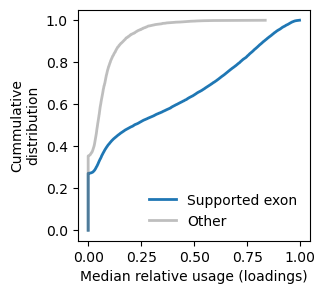

In [443]:
fig, ax = plt.subplots(figsize=(3, 3))

ax.plot(sorted(isoforms_anot_L), np.arange(len(isoforms_anot_L))/len(isoforms_anot_L), c='tab:blue', linewidth=2, label='Supported exon')
ax.plot(sorted(isoforms_unanot_L), np.arange(len(isoforms_unanot_L))/len(isoforms_unanot_L), c='tab:gray', alpha=0.5, linewidth=2, label='Other')
ax.set_xlabel('Median relative usage (loadings)')
ax.set_ylabel('Cummulative\ndistribution')
ax.legend(frameon=False)
# plt.plot(np.arange(len(EL_unannotated))/len(EL_unannotated), sorted(EL_unannotated))

plt.savefig('../code/scratch_figures/figure2/cassette_exons.relative_usage.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure2/cassette_exons.relative_usage.png', bbox_inches='tight', dpi=500)

In [150]:
len(pd.Index(snmf_vastdb_cassette_exons_confirmed.annot).union(pd.Index(gencode_exon.annot).intersection(pd.Index(snmf_exon.annot))).unique())

13058

In [356]:
pd.Index(gencode_exon.annot)

Index(['chr1:973186:973326:973010:973500',
       'chr1:1212638:1212704:1212138:1212992',
       'chr1:1337018:1337055:1336515:1337977',
       'chr1:1454345:1454500:1452434:1455460',
       'chr1:1487863:1487914:1486668:1489204',
       'chr1:1520548:1520617:1520306:1522744',
       'chr1:1624991:1625185:1624901:1625286',
       'chr1:1690976:1691393:1676846:1692449',
       'chr1:1755374:1755476:1754698:1756258',
       'chr1:1839190:1839238:1825499:1890820',
       ...
       'chrX:150795418:150795486:150795289:150831231',
       'chrX:153546088:153546129:153543168:153547835',
       'chrX:153863368:153863379:153862894:153863477',
       'chrX:153941950:153942031:153941653:153942855',
       'chrX:154092184:154092307:154032557:154097604',
       'chrX:154352553:154352675:154352447:154352772',
       'chrX:154357251:154357274:154355072:154357434',
       'chrX:154414101:154414190:154413567:154419543',
       'chrX:154486228:154486333:154485979:154486537',
       'chrX:155046509:15504

In [42]:
annot_by_both = pd.Index(gencode_exon.annot).intersection(pd.Index(snmf_exon.annot)).intersection(pd.Index(snmf_vastdb_cassette_exons_confirmed.annot))
annot_by_any = pd.Index(gencode_exon.annot).intersection(pd.Index(snmf_exon.annot)).union(pd.Index(snmf_vastdb_cassette_exons_confirmed.annot))

annot_by_one = annot_by_any.difference(annot_by_both)

transcripts_annotated = pd.Index(snmf_gencode_exons.transcripts).union(pd.Index(snmf_vastdb_exons.transcripts)).union(
    pd.Index(snmf_junctions_cassette_exons.transcripts)
)

is_exon = pd.Index(snmf_cassette_exons.loc[snmf_cassette_exons.transcripts.isin(transcripts_annotated)].annot.unique())
is_exon_only = is_exon.difference(annot_by_any)

overlap_with_exon = pd.Index(bad_overlap.annot.unique())

no_overlap = pd.Index(bad_no_overlap.annot.unique())


transcripts_by_both = snmf_cassette_exons.loc[snmf_cassette_exons.annot.isin(annot_by_both)].transcripts.unique()
transcripts_by_one = snmf_cassette_exons.loc[snmf_cassette_exons.annot.isin(annot_by_one)].transcripts.unique()
transcripts_exon_only = snmf_cassette_exons.loc[snmf_cassette_exons.annot.isin(is_exon_only)].transcripts.unique()
transcripts_overlap = snmf_cassette_exons.loc[snmf_cassette_exons.annot.isin(overlap_with_exon)].transcripts.unique()
transcripts_no_overlap = snmf_cassette_exons.loc[snmf_cassette_exons.annot.isin(no_overlap)].transcripts.unique()

In [43]:
len(annot_by_both)

3003

In [44]:
len(annot_by_one)

10055

In [45]:
len(is_exon_only)

6597

In [46]:
len(overlap_with_exon)

3758

In [151]:
is_exon_only

Index(['chr10:100178133:100178194:100176070:100185514',
       'chr10:100179201:100179247:100178194:100183756',
       'chr10:100250248:100250332:100246935:100253421',
       'chr10:100356532:100356764:100354632:100360734',
       'chr10:100950676:100956537:100950207:100959428',
       'chr10:100973547:100973609:100973277:100977632',
       'chr10:100990436:100990543:100989884:100990869',
       'chr10:101037382:101038692:101037203:101039175',
       'chr10:101039175:101039222:101037203:101039489',
       'chr10:101580248:101580416:101579817:101582763',
       ...
       'chrX:75293472:75293514:75274640:75296342',
       'chrX:75296342:75296411:75274640:75297491',
       'chrX:75297491:75297553:75274640:75299735',
       'chrX:75424652:75424784:75421990:75429078',
       'chrX:78020945:78021079:78020398:78029250',
       'chrX:78042585:78042788:78040733:78043317',
       'chrX:80717573:80717759:80704846:80719489',
       'chrX:80791854:80791952:80745729:80793622',
       'chrX:85054344

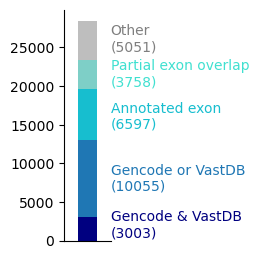

In [48]:
fig, ax = plt.subplots(figsize=(0.6, 3))
ax.bar([0], [28464], color='tab:gray', alpha=0.5, label='Other')
ax.bar([0], [23413], color='turquoise', alpha=0.5, label='Partial overlap')
ax.bar([0], [19655], color='tab:cyan', label='Annotated exon')
# ax.bar([0], [18629], color='tab:green')
ax.bar([0], [13058], color='tab:blue', label='Annotated\ncassette exon')
ax.bar([0], [3003], color='navy', label='Gencode & VastDB\ncassette exon')
ax.set_xlim([-1, 1])
ax.spines[['right', 'top']].set_visible(False)
ax.set_xticks([])
ax.text(1, 500, 'Gencode & VastDB\n(3003)', c='navy')
ax.text(1, 6500, 'Gencode or VastDB\n(10055)', c='tab:blue')
ax.text(1, 14500, 'Annotated exon\n(6597)', c='tab:cyan')
ax.text(1, 20000, 'Partial exon overlap\n(3758)', c='turquoise')
ax.text(1, 24500, 'Other\n(5051)', c='tab:gray')

# ax.legend(frameon=False, bbox_to_anchor =(2, 0.5))

plt.savefig('../code/scratch_figures/figure2/cassette_exons.barplot.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure2/cassette_exons.barplot.png', bbox_inches='tight', dpi=500)

In [49]:
def get_L_for_transcripts(transcripts_list, EL):
    df = pd.DataFrame()
    isoforms = []
    tr_ = []
    for tr in transcripts_list:
        iso = tr.split('|')
        isoforms.extend(iso)
        tr_.extend([tr]*len(iso))
    
    df['transcript'] = tr_
    df['isoform'] = isoforms
    
    samples = [x for x in EL.columns if x.startswith('GTEX-')]
    EL_slice = EL.reindex(df.isoform).fillna(0.001)
    merged = df.merge(EL_slice, right_index=True, left_on = 'isoform').drop_duplicates()
    
    
    return merged.groupby('transcript')[samples].sum()

In [50]:
transcripts_by_both = snmf_cassette_exons.loc[snmf_cassette_exons.annot.isin(annot_by_both)].transcripts.unique()
transcripts_by_one = snmf_cassette_exons.loc[snmf_cassette_exons.annot.isin(annot_by_one)].transcripts.unique()
transcripts_exon_only = snmf_cassette_exons.loc[snmf_cassette_exons.annot.isin(is_exon_only)].transcripts.unique()
transcripts_overlap = snmf_cassette_exons.loc[snmf_cassette_exons.annot.isin(overlap_with_exon)].transcripts.unique()
transcripts_no_overlap = snmf_cassette_exons.loc[snmf_cassette_exons.annot.isin(no_overlap)].transcripts.unique()


EL_section = get_L_for_transcripts(transcripts_by_both, EL)
EL_by_both = np.array(EL_section.median(axis=1))
EL_Q9 = np.array(EL_section.quantile(0.9, axis=1))
EL_Q1 = np.array(EL_section.quantile(0.1, axis=1))
diff_EL_by_both = EL_Q9 - EL_Q1

EL_section = get_L_for_transcripts(transcripts_by_one, EL)
EL_by_one = np.array(EL_section.median(axis=1))
EL_Q9 = np.array(EL_section.quantile(0.9, axis=1))
EL_Q1 = np.array(EL_section.quantile(0.1, axis=1))
diff_EL_by_one = EL_Q9 - EL_Q1

EL_section = get_L_for_transcripts(transcripts_exon_only, EL)
EL_exon_only = np.array(EL_section.median(axis=1))
EL_Q9 = np.array(EL_section.quantile(0.9, axis=1))
EL_Q1 = np.array(EL_section.quantile(0.1, axis=1))
diff_EL_exon_only = EL_Q9 - EL_Q1

EL_section = get_L_for_transcripts(transcripts_overlap, EL)
EL_overlap = np.array(EL_section.median(axis=1))
EL_Q9 = np.array(EL_section.quantile(0.9, axis=1))
EL_Q1 = np.array(EL_section.quantile(0.1, axis=1))
diff_EL_overlap = EL_Q9 - EL_Q1

EL_section = get_L_for_transcripts(transcripts_no_overlap, EL)
EL_no_overlap = np.array(EL_section.median(axis=1))
EL_Q9 = np.array(EL_section.quantile(0.9, axis=1))
EL_Q1 = np.array(EL_section.quantile(0.1, axis=1))
diff_EL_no_overlap = EL_Q9 - EL_Q1

In [51]:
EL_by_both

array([0.2873, 0.7568, 0.6391, ..., 0.2413, 0.9104, 0.5751])

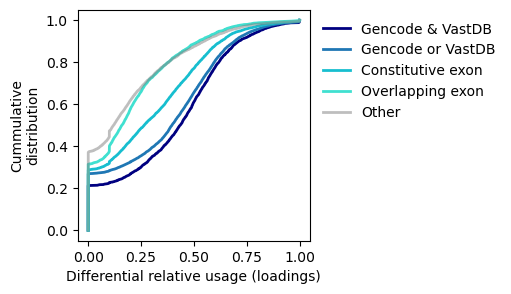

In [52]:
fig, ax = plt.subplots(figsize=(3, 3))

ax.plot(sorted(diff_EL_by_both), np.arange(len(diff_EL_by_both))/len(diff_EL_by_both), c='navy', linewidth=2, label='Gencode & VastDB')
ax.plot(sorted(diff_EL_by_one), np.arange(len(diff_EL_by_one))/len(diff_EL_by_one), c='tab:blue', linewidth=2, label='Gencode or VastDB')
ax.plot(sorted(diff_EL_exon_only), np.arange(len(diff_EL_exon_only))/len(diff_EL_exon_only), c='tab:cyan', linewidth=2, label='Constitutive exon')
ax.plot(sorted(diff_EL_overlap), np.arange(len(diff_EL_overlap))/len(diff_EL_overlap), c='turquoise', linewidth=2, label='Overlapping exon')

ax.plot(sorted(diff_EL_no_overlap), np.arange(len(diff_EL_no_overlap))/len(diff_EL_no_overlap), c='tab:gray', alpha=0.5, linewidth=2, label='Other')
ax.set_xlabel('Differential relative usage (loadings)')
ax.set_ylabel('Cummulative\ndistribution')
ax.legend(frameon=False, bbox_to_anchor = (1, 1))
# plt.plot(np.arange(len(EL_unannotated))/len(EL_unannotated), sorted(EL_unannotated))

plt.savefig('../code/scratch_figures/figure2/cassette_exons.diff_in_L.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure2/cassette_exons.diff_in_L.png', bbox_inches='tight', dpi=500)

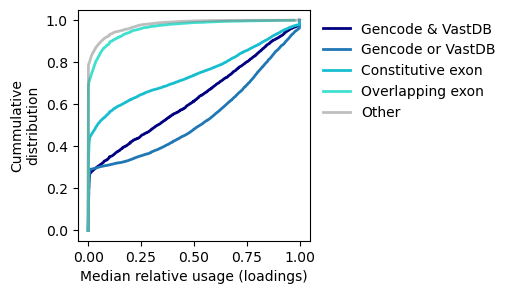

In [53]:
fig, ax = plt.subplots(figsize=(3, 3))

ax.plot(sorted(EL_by_both), np.arange(len(EL_by_both))/len(EL_by_both), c='navy', linewidth=2, label='Gencode & VastDB')
ax.plot(sorted(EL_by_one), np.arange(len(EL_by_one))/len(EL_by_one), c='tab:blue', linewidth=2, label='Gencode or VastDB')
ax.plot(sorted(EL_exon_only), np.arange(len(EL_exon_only))/len(EL_exon_only), c='tab:cyan', linewidth=2, label='Constitutive exon')
ax.plot(sorted(EL_overlap), np.arange(len(EL_overlap))/len(EL_overlap), c='turquoise', linewidth=2, label='Overlapping exon')

ax.plot(sorted(EL_no_overlap), np.arange(len(EL_no_overlap))/len(EL_no_overlap), c='tab:gray', alpha=0.5, linewidth=2, label='Other')
ax.set_xlabel('Median relative usage (loadings)')
ax.set_ylabel('Cummulative\ndistribution')
ax.legend(frameon=False, bbox_to_anchor = (1, 1))
# plt.plot(np.arange(len(EL_unannotated))/len(EL_unannotated), sorted(EL_unannotated))

plt.savefig('../code/scratch_figures/figure2/cassette_exons.median_in_L.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure2/cassette_exons.median_in_L.png', bbox_inches='tight', dpi=500)

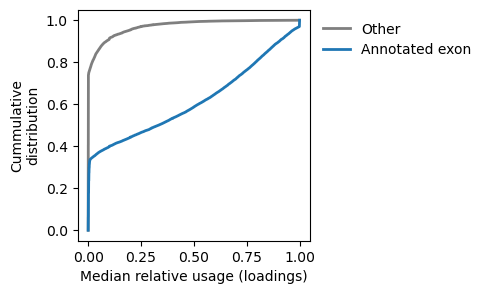

In [54]:
fig, ax = plt.subplots(figsize=(3, 3))

X = list(EL_by_both) + list(EL_by_one) + list(EL_exon_only)
Y = list(EL_overlap) + list(EL_no_overlap)


ax.plot(sorted(Y), np.arange(len(Y))/len(Y), c='tab:gray', linewidth=2, label='Other')

ax.plot(sorted(X), np.arange(len(X))/len(X), c='tab:blue', linewidth=2, label='Annotated exon')


ax.set_xlabel('Median relative usage (loadings)')
ax.set_ylabel('Cummulative\ndistribution')
ax.legend(frameon=False, bbox_to_anchor = (1, 1))
# plt.plot(np.arange(len(EL_unannotated))/len(EL_unannotated), sorted(EL_unannotated))

plt.savefig('../code/scratch_figures/figure2/cassette_exons.median_in_L_two_categories.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure2/cassette_exons.median_in_L_two_categories.png', bbox_inches='tight', dpi=500)

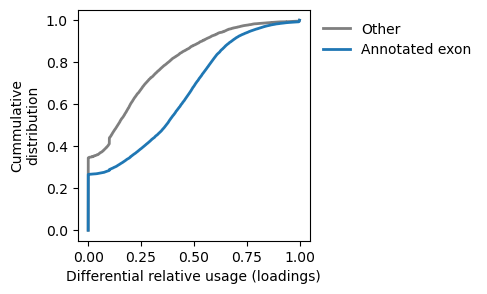

In [55]:
fig, ax = plt.subplots(figsize=(3, 3))

X = list(diff_EL_by_both) + list(diff_EL_by_one) + list(diff_EL_exon_only)
Y = list(diff_EL_overlap) + list(diff_EL_no_overlap)


ax.plot(sorted(Y), np.arange(len(Y))/len(Y), c='tab:gray', linewidth=2, label='Other')

ax.plot(sorted(X), np.arange(len(X))/len(X), c='tab:blue', linewidth=2, label='Annotated exon')


ax.set_xlabel('Differential relative usage (loadings)')
ax.set_ylabel('Cummulative\ndistribution')
ax.legend(frameon=False, bbox_to_anchor = (1, 1))
# plt.plot(np.arange(len(EL_unannotated))/len(EL_unannotated), sorted(EL_unannotated))

plt.savefig('../code/scratch_figures/figure2/cassette_exons.median_diff_L_two_categories.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure2/cassette_exons.median_diff_L_two_categories.png', bbox_inches='tight', dpi=500)

In [56]:
EL_section = get_L_for_transcripts(transcripts_by_both, EL)

In [57]:
np.array(EL_section.mean(axis=1))

array([0.2982748, 0.7000074, 0.6154065, ..., 0.2970787, 0.8491943,
       0.5685577])

In [58]:
EL_samples = [x for x in EL.columns if x.startswith('GTEX-')]
EL_no_overlap = EL.reindex(transcripts_no_overlap).dropna()[EL_samples]

In [147]:
EL_no_overlap.quantile(axis=1).sort_values()[:1960]

pid
ENSG00000188976.isoform_3     0.00000
ENSG00000133424.isoform_10    0.00000
ENSG00000133424.isoform_5     0.00000
ENSG00000133424.isoform_6     0.00000
ENSG00000133424.isoform_2     0.00000
                               ...   
ENSG00000154217.isoform_9     0.01520
ENSG00000188641.isoform_7     0.01530
ENSG00000086102.isoform_5     0.01550
ENSG00000068305.isoform_3     0.01550
ENSG00000127527.isoform_10    0.01555
Name: 0.5, Length: 1960, dtype: float64

In [ ]:
is_exon_only

In [161]:
EL_section = get_L_for_transcripts(transcripts_exon_only, EL)

In [162]:
EL_section

,GTEX-1117F-0426-SM-5EGHI,GTEX-1122O-2426-SM-5GIDN,GTEX-1128S-2426-SM-5H11B,GTEX-113JC-2726-SM-5EGIS,GTEX-11DXX-2726-SM-5PNXO,GTEX-11EM3-2126-SM-5H11M,GTEX-11EMC-2626-SM-59864,GTEX-11GSP-2726-SM-5A5LJ,GTEX-11I78-2426-SM-5A5K9,GTEX-11P81-2526-SM-5GU6H,...,GTEX-13PVQ-0011-R7a-SM-5L3G3,GTEX-13RTJ-0011-R7b-SM-5P9JS,GTEX-13VXU-0011-R7b-SM-5SI72,GTEX-13X6I-0011-R7b-SM-5PNWP,GTEX-13X6J-0011-R7b-SM-5PNUC,GTEX-1445S-0011-R7b-SM-5PNUG,GTEX-144GL-0011-R7b-SM-5P9HX,GTEX-144GO-0011-R7b-SM-5S2TT,GTEX-145MG-0011-R7b-SM-5P9JY,GTEX-145MH-0011-R7a-SM-5PNWH
transcript,,,,,,,,,,,,,,,,,,,,,
ENSG00000000460.isoform_1|ENSG00000000460.isoform_2|ENSG00000000460.isoform_3,1.0000,0.9998,0.9997,1.0000,1.0000,1.0001,1.0001,0.9998,0.9997,0.9000,...,0.9998,1.0002,1.0002,0.9999,0.9999,0.9997,0.9998,0.9000,0.9998,1.0001
ENSG00000000938.isoform_5,0.0018,0.0018,0.2641,0.0019,0.1172,0.0164,0.0026,0.0022,0.0024,0.0046,...,0.0004,0.1659,0.0006,0.0007,0.0419,0.1022,0.1165,0.0729,0.0011,0.0011
ENSG00000001036.isoform_7,0.0001,0.0651,0.0002,0.2235,0.0001,0.2545,0.0001,0.1062,0.0002,0.0002,...,0.0000,0.0869,0.0000,0.0000,0.0392,0.0001,0.1623,0.0001,0.0629,0.0000
ENSG00000001497.isoform_1,0.0001,0.0839,0.0598,0.0824,0.0458,0.0001,0.0526,0.0749,0.0548,0.0581,...,0.0000,0.2852,0.3545,0.2516,0.3157,0.1620,0.1779,0.0001,0.2696,0.4278
ENSG00000001497.isoform_9,0.0030,0.0001,0.0001,0.0002,0.0661,0.0731,0.0001,0.0847,0.0002,0.0518,...,0.3735,0.0459,0.1543,0.1519,0.0306,0.3596,0.3489,0.6519,0.3119,0.0001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000283361.isoform_1,0.0010,0.0010,0.0010,0.0010,0.0010,0.0010,0.0010,0.0010,0.0010,0.0010,...,0.0010,0.0010,0.0010,0.0010,0.0010,0.0010,0.0010,0.0010,0.0010,0.0010
ENSG00000283361.isoform_3,0.0010,0.0010,0.0010,0.0010,0.0010,0.0010,0.0010,0.0010,0.0010,0.0010,...,0.0010,0.0010,0.0010,0.0010,0.0010,0.0010,0.0010,0.0010,0.0010,0.0010
ENSG00000283361.isoform_4,0.0010,0.0010,0.0010,0.0010,0.0010,0.0010,0.0010,0.0010,0.0010,0.0010,...,0.0010,0.0010,0.0010,0.0010,0.0010,0.0010,0.0010,0.0010,0.0010,0.0010


In [163]:
EL_samples = [x for x in EL.columns if x.startswith('GTEX-')]
EL_no_overlap = EL.reindex(transcripts_exon_only).dropna()[EL_samples]

In [168]:
transcripts_exon_only

array(['ENSG00000188976.isoform_1|ENSG00000188976.isoform_2|ENSG00000188976.isoform_4|ENSG00000188976.isoform_5|ENSG00000188976.isoform_6|ENSG00000188976.isoform_7',
       'ENSG00000188976.isoform_1|ENSG00000188976.isoform_4|ENSG00000188976.isoform_5|ENSG00000188976.isoform_7',
       'ENSG00000188976.isoform_1|ENSG00000188976.isoform_4|ENSG00000188976.isoform_5|ENSG00000188976.isoform_6|ENSG00000188976.isoform_7',
       ..., 'ENSG00000130830.isoform_1|ENSG00000130830.isoform_2',
       'ENSG00000185010.isoform_2', 'ENSG00000155959.isoform_1'],
      dtype=object)

In [180]:
(EL_section.quantile(0.75, axis=1) - EL_section.quantile(0.25, axis=1)).sort_values()[-50:]

transcript
ENSG00000145349.isoform_1|ENSG00000145349.isoform_2|ENSG00000145349.isoform_6                                                                                                             0.588425
ENSG00000137601.isoform_1|ENSG00000137601.isoform_10|ENSG00000137601.isoform_5|ENSG00000137601.isoform_9|ENSG00000137601.isoform_3                                                        0.589800
ENSG00000185104.isoform_2|ENSG00000185104.isoform_3|ENSG00000185104.isoform_4|ENSG00000185104.isoform_5|ENSG00000185104.isoform_7|ENSG00000185104.isoform_8|ENSG00000185104.isoform_9     0.589975
ENSG00000170921.isoform_10|ENSG00000170921.isoform_5|ENSG00000170921.isoform_7                                                                                                            0.591075
ENSG00000136828.isoform_1|ENSG00000136828.isoform_6|ENSG00000136828.isoform_9                                                                                                             0.592450
ENSG0000003821

In [184]:
snmf_exons.loc[snmf_exons.gene_id == 'ENSG00000162994'].end.max() - snmf_exons.loc[snmf_exons.gene_id == 'ENSG00000162994'].start.min()

59841

In [63]:
df = pd.DataFrame()
isoforms = []
tr_ = []
for tr in transcripts_no_overlap:
    iso = tr.split('|')
    isoforms.extend(iso)
    tr_.extend([tr]*len(iso))

df['transcript'] = tr_
df['isoform'] = isoforms
    
df.loc[df.isoform == 'ENSG00000137075.isoform_2']

,transcript,isoform
3954,ENSG00000137075.isoform_2,ENSG00000137075.isoform_2


In [65]:
snmf_exons_bed = '/project2/mstephens/cfbuenabadn/gtex-stm/code/ebpmf_models/filtered/snmf_10/tables/snmf.merged_isoforms.exons.sorted.bed.gz'
snmf_exons = pd.read_csv(snmf_exons_bed, sep='\t', names = ['chrom', 'start', 'end', 'gene_id', 
                                                 'transcript_id', 'strand', 'factors', 'exon_id'])

In [66]:
snmf_exons.loc[snmf_exons.transcript_id == 'ENSG00000137075.isoform_2']

,chrom,start,end,gene_id,transcript_id,strand,factors,exon_id
713309,chr9,36336427,36339814,ENSG00000137075,ENSG00000137075.isoform_2,-,factor_1:factor_4:factor_6:factor_7,exon_1
713313,chr9,36342325,36342424,ENSG00000137075,ENSG00000137075.isoform_2,-,factor_1:factor_4:factor_6:factor_7,exon_2
713317,chr9,36344832,36344953,ENSG00000137075,ENSG00000137075.isoform_2,-,factor_1:factor_4:factor_6:factor_7,exon_3
713318,chr9,36347119,36347152,ENSG00000137075,ENSG00000137075.isoform_2,-,factor_1:factor_4:factor_6:factor_7,exon_4
713319,chr9,36351115,36351199,ENSG00000137075,ENSG00000137075.isoform_2,-,factor_1:factor_4:factor_6:factor_7,exon_5
713321,chr9,36352742,36352848,ENSG00000137075,ENSG00000137075.isoform_2,-,factor_1:factor_4:factor_6:factor_7,exon_6
713326,chr9,36353170,36353331,ENSG00000137075,ENSG00000137075.isoform_2,-,factor_1:factor_4:factor_6:factor_7,exon_7
713327,chr9,36356303,36356473,ENSG00000137075,ENSG00000137075.isoform_2,-,factor_1:factor_4:factor_6:factor_7,exon_8
713332,chr9,36357775,36357942,ENSG00000137075,ENSG00000137075.isoform_2,-,factor_1:factor_4:factor_6:factor_7,exon_9
713334,chr9,36369719,36369932,ENSG00000137075,ENSG00000137075.isoform_2,-,factor_1:factor_4:factor_6:factor_7,exon_10


In [62]:
snmf_cassette_exons.loc[snmf_cassette_exons.transcripts == 'ENSG00000187605.isoform_6']

,chrom,start,end,gene,exon_coordinates,strand,intron_start,intron_end,flanking1_start,flanking2_end,transcripts,exon_name,annot
14674,chr2,74025045,74025177,ENSG00000187605,chr2:74025045-74025177,+,74003166,74046278,74003110,74048411,ENSG00000187605.isoform_6,ENSG00000187605:1,chr2:74025045:74025177:74003166:74046278
14675,chr2,74061630,74061798,ENSG00000187605,chr2:74061630-74061798,+,74048411,74073549,74046278,74073639,ENSG00000187605.isoform_6,ENSG00000187605:1,chr2:74061630:74061798:74048411:74073549


In [77]:
snmf_ri = pd.read_csv('../code/CoveragePlots/bed_files/introns/snmf.retained_introns.bed.gz', sep='\t',
                     names = ['chrom', 'start', 'end', 'intron_name', 'transcripts', 'strand'])
snmf_ri['gene_id'] = snmf_ri.intron_name.apply(lambda x: x.split('_')[0])

In [78]:
snmf_ri.shape

(83553, 7)

In [79]:
len(snmf_ri.gene_id.unique())

12472

In [132]:
cassette_exons = pd.read_csv('../code/ebpmf_models/filtered/snmf_10/tables/cassette_exons.bed.gz', sep='\t')

annotation = pd.read_csv('../code/ebpmf_models/filtered/snmf_10/tables/annotated.snmf.merged_isoforms.tab.gz', sep='\t')
annotation['gene_id'] = annotation.transcript.apply(lambda x: x.split('.')[0])
second_annotation = pd.read_csv('../code/ebpmf_models/filtered/snmf_10/tables/second_annotation.snmf.merged_isoforms.tab.gz', sep='\t',
                               names = ['gene', 'transcript', 'chain', 'ref_transcript', 'intron_retention', 'utr'])

len(second_annotation.loc[~second_annotation.utr.isin(['no_utr', '.'])].gene.unique())

2906

In [138]:
len(second_annotation.loc[~second_annotation.utr.isin(['no_utr', '.'])].transcript.unique())

8013

In [118]:
len(cassette_exons.gene.unique())

8774

In [120]:
pd.Index(annotation.loc[(annotation.appris_ref.apply(
    lambda x: ('intron.chain' in x) or ('ref.transcript' in x) or ('super' in x) or ('sub' in x)
) | (annotation.gencode_ref != '.'))].gene_id.unique()).union(pd.Index(second_annotation.loc[second_annotation.chain == 'annotated_chain'].gene.unique())).unique()

Index(['ENSG00000000003', 'ENSG00000000005', 'ENSG00000000419',
       'ENSG00000000457', 'ENSG00000000938', 'ENSG00000001167',
       'ENSG00000001460', 'ENSG00000001461', 'ENSG00000001497',
       'ENSG00000001561',
       ...
       'ENSG00000281106', 'ENSG00000282933', 'ENSG00000283071',
       'ENSG00000283199', 'ENSG00000283378', 'ENSG00000283526',
       'ENSG00000283528', 'ENSG00000283632', 'ENSG00000283703',
       'ENSG00000284024'],
      dtype='object', length=11597)

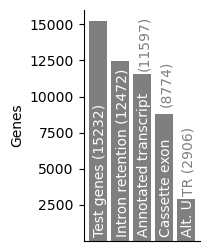

In [136]:
fig, ax = plt.subplots(figsize=(1.5, 3))

ax.bar(['Test genes', 'Intron retention', 'Annotated transcript', 'Cassette exon', 'Alt.UTR'], [15232, 12472, 11597, 8774, 2906],
       color = ['tab:gray', 'tab:gray', 'tab:gray', 'tab:gray', 'tab:gray'])
ax.set_xticks([])

ax.text(-0.2, 500, 'Test genes (15232)', rotation=90, c='white')

ax.text(0.8, 500, 'Intron retention (12472)', rotation=90, c='white')
ax.text(1.8, 500, 'Annotated transcript', rotation=90, c='white')
ax.text(1.8, 12000, '(11597)', rotation=90, c='tab:gray')
ax.text(2.8, 500, 'Cassette exon', rotation=90, c='white')
ax.text(2.8, 9500, '(8774)', rotation=90, c='tab:gray')
ax.text(3.8, 500, 'Alt. U', rotation=90, c='white')
ax.text(3.8, 3300, 'TR (2906)', rotation=90, c='tab:gray')

ax.set_yticks([2500, 5000, 7500, 10000, 12500, 15000])#(['0', '1e5', '2e5', '3e5', '4e5', '5e5', '6e5'])
ax.set_ylabel('Genes')
ax.spines[['right', 'top']].set_visible(False)


plt.savefig('../code/scratch_figures/figure2/gene_annotation_barplot_gray.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure2/gene_annotation_barplot_gray.png', bbox_inches='tight', dpi=500)

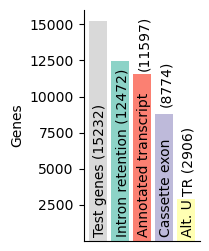

In [6]:
colores = sns.color_palette('Set3')

fig, ax = plt.subplots(figsize=(1.5, 3))

ax.bar(['Test genes', 'Intron retention', 'Annotated transcript', 'Cassette exon', 'Alt.UTR'], [15232, 12472, 11597, 8774, 2906],
       color = [colores[8], colores[0], colores[3], colores[2], colores[1]])
ax.set_xticks([])

ax.text(-0.2, 500, 'Test genes (15232)', rotation=90, c='black')

ax.text(0.8, 500, 'Intron retention (12472)', rotation=90, c='black')
ax.text(1.8, 500, 'Annotated transcript', rotation=90, c='black')
ax.text(1.8, 12000, '(11597)', rotation=90, c='black')
ax.text(2.8, 500, 'Cassette exon', rotation=90, c='black')
ax.text(2.8, 9500, '(8774)', rotation=90, c='black')
ax.text(3.8, 500, 'Alt. U', rotation=90, c='black')
ax.text(3.8, 3300, 'TR (2906)', rotation=90, c='black')

ax.set_yticks([2500, 5000, 7500, 10000, 12500, 15000])#(['0', '1e5', '2e5', '3e5', '4e5', '5e5', '6e5'])
ax.set_ylabel('Genes')
ax.spines[['right', 'top']].set_visible(False)


plt.savefig('../code/scratch_figures/figure2/gene_annotation_barplot_colors.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure2/gene_annotation_barplot_colors.png', bbox_inches='tight', dpi=500)

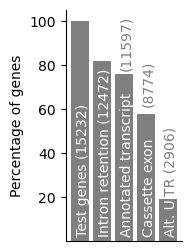

In [149]:
fig, ax = plt.subplots(figsize=(1.5, 3))

ax.bar(['Test genes', 'Intron retention', 'Annotated transcript', 'Cassette exon', 'Alt.UTR'], [15232/15232, 12472/15232, 11597/15232, 8774/15232, 2906/15232],
       color = ['tab:gray', 'tab:gray', 'tab:gray', 'tab:gray', 'tab:gray'])
ax.set_xticks([])

ax.text(-0.2, 500/15232, 'Test genes (15232)', rotation=90, c='white')

ax.text(0.8, 500/15232, 'Intron retention (12472)', rotation=90, c='white')
ax.text(1.8, 500/15232, 'Annotated transcript', rotation=90, c='white')
ax.text(1.8, 12000/15232, '(11597)', rotation=90, c='tab:gray')
ax.text(2.8, 500/15232, 'Cassette exon', rotation=90, c='white')
ax.text(2.8, 9500/15232, '(8774)', rotation=90, c='tab:gray')
ax.text(3.8, 500/15232, 'Alt. U', rotation=90, c='white')
ax.text(3.8, 3300/15232, 'TR (2906)', rotation=90, c='tab:gray')

ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1])#(['0', '1e5', '2e5', '3e5', '4e5', '5e5', '6e5'])
ax.set_yticklabels(['20', '40', '60', '80', '100'])
ax.set_ylabel('Percentage of genes')
ax.spines[['right', 'top']].set_visible(False)


plt.savefig('../code/scratch_figures/figure2/gene_annotation_barplot_gray_percentages.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure2/gene_annotation_barplot_gray_percentages.png', bbox_inches='tight', dpi=500)

In [122]:
transcripts_first = pd.Index(annotation.loc[(annotation.appris_ref.apply(
    lambda x: ('intron.chain' in x) or ('ref.transcript' in x) or ('super' in x) or ('sub' in x)
) | (annotation.gencode_ref != '.'))].appris_transcript)

transcripts_second = pd.Index(second_annotation.loc[second_annotation.chain == 'annotated_chain'].ref_transcript.apply(lambda x: x.split(':')[-1]))

transcripts_all = transcripts_first.union(transcripts_second).unique()

In [123]:
transcripts_all

Index(['ENST00000000442', 'ENST00000001146', 'ENST00000002125',
       'ENST00000002501', 'ENST00000002596', 'ENST00000002829',
       'ENST00000003084', 'ENST00000003583', 'ENST00000004103',
       'ENST00000005178',
       ...
       'ENST00000710415', 'ENST00000710568', 'ENST00000710615',
       'ENST00000710634', 'ENST00000710691', 'ENST00000710837',
       'ENST00000710839', 'ENST00000710853', 'ENST00000710881',
       'ENST00000711046'],
      dtype='object', length=18813)

In [124]:
cassette_exons.shape

(28464, 12)

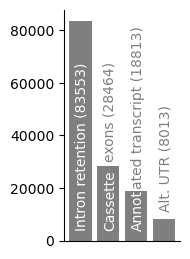

In [141]:
fig, ax = plt.subplots(figsize=(1.5, 3))

ax.bar(['Intron retention', 'Cassette exon', 'Annotated transcript', 'Alt.UTR'], [83553, 28464, 18813, 8013],
       color = ['tab:gray', 'tab:gray', 'tab:gray', 'tab:gray'])
ax.set_xticks([])

ax.text(-0.2, 5000, 'Intron retention (83553)', rotation=90, c='white')

ax.text(0.8, 5000, 'Cassette', rotation=90, c='white')
ax.text(0.8, 31000, 'exons (28464)', rotation=90, c='tab:gray')
ax.text(1.8, 5000, 'Annot', rotation=90, c='white')

ax.text(1.8, 21000, 'ated transcript (18813)', rotation=90, c='tab:gray')
ax.text(2.8, 12000, 'Alt. UTR (8013)', rotation=90, c='tab:gray')

# ax.set_yticks([2500, 5000, 7500, 10000, 12500, 15000])#(['0', '1e5', '2e5', '3e5', '4e5', '5e5', '6e5'])
# ax.set_ylabel('Genes')
ax.spines[['right', 'top']].set_visible(False)


plt.savefig('../code/scratch_figures/figure2/all_annotation_barplot_gray.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure2/all_annotation_barplot_gray.png', bbox_inches='tight', dpi=500)